# Communities

Building on the Python Network Graph toolkit, let's build a tool to help people discover their communities in *The Organization*. This tool will:

* Allow the user to choose 1-3 attributes to cluster *peers*
* Visualize *nearby* peers in the organization
* Customize how information is styled/displayed in the graph

## Expanded Toolkit

Import previous work with 
https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html

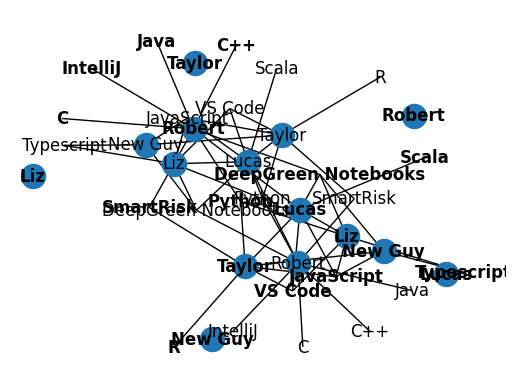

In [2]:
# from __future__ import annotations # manually add to converted file until fixed
toolkit = __import__("Network Graphs with Python")

In [3]:
import people
import pandas as pd
import numpy as np

In [4]:
import dash
import dash_bootstrap_components as dbc

app = dash.Dash(
    __name__,
    title="Peer Finder",
    external_stylesheets=[dbc.icons.FONT_AWESOME],
    #external_scripts=["https://unpkg.com/dash.nprogress@latest/dist/dash.nprogress.js"],
)

languages.update(
    {
        "javascript": [
            "chanmi6",
            *people.reports(acf2="chanmi6", columns=["ACF2"]).ACF2.tolist(),
            "javorj2",
            *people.reports(acf2="javorj2", columns=["ACF2"]).ACF2.tolist(),
            "herret2",
            *people.reports(acf2="herret2", columns=["ACF2"]).ACF2.tolist(),
        ],  # Mike chan + Tom
        "scala": [
            "chanmi6",
            *people.reports(acf2="chanmi6", columns=["ACF2"]).ACF2.tolist(),
            "tab2635",
            *people.reports(acf2="tab2635", columns=["ACF2"]).ACF2.tolist(),
        ],  # Mike Chan + Mark Porter
    }
)

In [8]:
def inverse_attribute_users_dict(attributes: dict[str,list[str]], attribute_name:str) -> pd.DataFrame:
    users = pd.DataFrame([attributes]).melt(var_name=attribute_name, value_name="ACF2").explode("ACF2")
    users[attribute_name] = users[attribute_name].apply(lambda attr: [attr])
    users = users.groupby("ACF2", as_index=False).sum()
    return users

In [9]:
def get_users(top:str, *, apps:list[str], languages:list[str]) -> pd.DataFrame:
    users = pd.merge(
        inverse_attribute_users_dict(attributes=apps, attribute_name="apps"),
        inverse_attribute_users_dict(attributes=languages, attribute_name="languages"),
        on="ACF2",
        how="outer"
    )

    tds = user.retry_smaller_chunks_indirects_and_self(
        acf2=top, 
        columns=["ACF2","FirstLast","FunctionalSupervisorACF2"]
    ).reset_index(drop=True)

    tds = pd.merge(
        tds,
        users,
        on="ACF2",
        how="outer"
    )

    tds = tds.dropna(subset=["FirstLast"], how="all") # keep the TDS people only ...
    return tds

In [11]:
import networkx as nx

graph_data = tds.copy()
graph_data["label"] = graph_data["FirstLast"]
graph_data = graph_data.rename(columns={"ACF2":"id","FunctionalSupervisorACF2":"manager"})
graph_data["person"] = True

In [12]:
rreplace = lambda string, replace, value: value.join(string.rsplit(replace, 1))

In [13]:
ATTRIBUTES = ["manager","languages","apps"]

from more_itertools import always_iterable
def populate_graph(graph_data:pd.DataFrame, attributes:list[str]=[]) -> nx.Graph:
    G = nx.DiGraph()
    G.add_nodes_from((person["id"], person) for person in graph_data.replace(np.nan, None).to_dict(orient="records"))
    
    for attribute in always_iterable(attributes):
        if not attribute == "manager":
            flag = rreplace(attribute, replace="s", value="") if attribute.endswith("s") else attribute # not plural
            toolkit.add_nodes_from_attributes(G, attribute=attribute, flag=flag)
            weight = 10
        else: # don't add (possibly) duplicate nodes for managers
            weight = max(10, 10 * (len(attributes) - 1))
        toolkit.add_edges_from_attributes(G, attribute=attribute, weight=weight) # this weight should be tweaked as more apps/languages are added
        
    return G

In [14]:
G = populate_graph(graph_data=graph_data)

## Who Are My People?

In [15]:
import matplotlib.pyplot as plt

FOCUS = ... # where to start?

ego = nx.ego_graph(G, FOCUS, undirected=True, radius=3)
ego_people = nx.subgraph_view(ego, filter_node=toolkit.just_people(G)).nodes()

# nx.draw_spring(ego, nodelist=ego_people, with_labels=True) # yuck! (11s to render, useful for demo)

In [16]:
# this is gross -- update to have smaller dot size + no annotations (show on hover only)
# toolkit.px_plot_network_graph(ego)

### Smaller neighbourhood

By including everyone that's connected at all, we have a BIG neighbourhood. We should be more selective!

In [17]:
N = 50

In [18]:
def filter_graph_to_nearby(G:nx.Graph, focus:str=FOCUS, *, N:int=N, radius:int=3) -> tuple[nx.Graph, dict[str,np.array]] :
    ego = nx.ego_graph(G, focus, undirected=True, radius=radius)
    ego_people = nx.subgraph_view(ego, filter_node=toolkit.just_people(ego)).nodes()

    similarities, layout = toolkit.spring_neighbours(ego, user=focus)

    #sorted_similarities = similarities.sel(person=focus).sortby(similarities.sel(person=focus))
    sorted_similarities = similarities.sortby(similarities)
    peers = sorted_similarities.person2[:N]
    peers = set(peers.data)

    attributes = set(node for node,person in ego.nodes(data="person") if not person)
    NEARBY_G = nx.subgraph_view(ego, filter_node=lambda n: n in peers or n in attributes)
    local_apps = set(attr for source,attr,flag in NEARBY_G.edges(data="apps") if flag and attr in attributes)
    local_languages = set(attr for source,attr,flag in NEARBY_G.edges(data="languages") if flag and attr in attributes)
    local_attributes = local_apps | local_languages

    NEARBY_G = nx.subgraph_view(NEARBY_G, filter_node=lambda n: n in peers or n in local_attributes)
    return NEARBY_G, layout

NEARBY_G, layout = filter_graph_to_nearby(G, focus=FOCUS)

## Cytoscape App

In [19]:
from dash import html, dcc, callback, Output, Input
import dash_cytoscape as cyto
import dash_bootstrap_components as dbc
import deepgreen.dash.components as dgc
import json

cyto.load_extra_layouts()

In [20]:
elements = nx.cytoscape_data(NEARBY_G).get("elements")

def spread_cyto_layout(layout:dict[str,np.array]) -> dict:
    SCALE = 1000
    return { # just use the spring layout from before (it doesn't fit very well ...)
        "name":"spread", # cola + spread out nodes
        "prelayout": {
            "name":"preset",
            "positions": {
                id: {"x":SCALE*array[0], "y": SCALE*array[1]}
                for id, array in layout.items()
            }, # use the pre-computed spring locations to start
        },
        "minDist": 20, # space nodes at least one node between
        "maxExpandIterations": 4, # Maximum number of expanding iterations, default 4
        "nodeDimensionsIncludeLabels": True,
        "randomize": False,
    }
def physics_cyto_layout(layout:dict[str,np.array]) -> dict:
    SCALE = 1000
    return { # just use the spring layout from before (it doesn't fit very well ...)
        "name":"cose", # cola + spread out nodes
        "positions": {
            id: {"x":SCALE*array[0], "y": SCALE*array[1]}
            for id, array in layout.items()
        }, # use the pre-computed spring locations to start
        "nodeDimensionsIncludeLabels": True,
        "animate": True,
        "animationDuration": 2000
    }
def preset_cyto_layout(layout: dict[str, np.array]) -> dict:
    SCALE = 1000
    return { # just use the spring layout from before (it doesn't fit very well ...)
        "name":"preset", # cola + spread out nodes
        "positions": {
            id: {"x":SCALE*array[0], "y": SCALE*array[1]}
            for id, array in layout.items()
        }, # use the pre-computed spring locations to start
        "animate": True, # default True
        "animationDuration": 2000, # duration of animation in ms if enabled
    }

my_cyto_layout = physics_cyto_layout

In [21]:
def stylesheet(focus:str=FOCUS, theme:str="light"):
    dark = theme == "dark"
    return [
    {
        "selector": "node",
        "style": {
            "font-size": 50,
            "color": "lightgrey" if dark else "darkgrey"
        }
    },
    {
        "selector": "edge",
        "style": {
            "line-color": "lightgrey" if dark else "darkgrey",
            "curve-style": "bezier",
            "width": 1,
            "opacity": 0.25,
            "font-size": 10,
            "text-rotation": "autorotate",
        },
    },    
    {"selector": "edge[?languages]", "style": {"label": "codes"}},
    {"selector": "edge[?apps]", "style": {"label": "uses"}},
    {"selector": "edge[?manager]", "style": {"label": "manages", "source-arrow-shape":"triangle"}},     
    {
        "selector": "node[?person]",
        "style": {
            "label": "data(label)",
            "background-color": "lightgreen" if dark else "green",
            "width": 25,
            "height": 25,            
            "font-size": 16
        },
    },
    {
        "selector": "node[?language]",
        "style": {
            "label": "data(name)",
            "background-color": "white" if dark else "black",
            "width": 5,
            "height": 5,
        },
    },
    {
        "selector": f"node[id='{focus}']",
        "style":{
            "width": 50,
            "height": 50,
            "font-size": 35,
            "color":"skyblue",
            "background-color":"skyblue",
            "z-index":10            
        }
    },
    {
        "selector": "node[?app]",
        "style": {"label": "data(name)", "width": 5, "height": 5},
    },
]

In [22]:
app.layout = html.Div(
    [
        dgc.header(),
        html.Datalist(
            children=[html.Option(value=acf2) for acf2 in graph_data.id.tolist()],
            id="names",
        ),
        dbc.Spinner(
            dbc.Row(
                [
                    dbc.Col(
                        dbc.InputGroup(
                            [
                                dbc.InputGroupText("Attributes:"),
                                dcc.Dropdown(
                                    id="attributes",
                                    options=[
                                        {"label": attribute, "value": attribute}
                                        for attribute in ATTRIBUTES
                                    ],
                                    multi=True,
                                    style={
                                        "min-width": "100px"
                                    },  # stay large enough to see the dropdown options
                                ),
                            ]
                        )
                    ),
                    dbc.Col(
                        dbc.InputGroup(
                            [
                                dbc.InputGroupText("Focus:"),
                                dbc.Input(
                                    id="name",
                                    debounce=True,
                                    type="search",
                                    list="names",
                                    value=FOCUS,
                                ),
                            ]
                        )
                    ),
                    dbc.Col(
                        [
                            dbc.InputGroup(
                                [
                                    dbc.InputGroupText("K-Nearest:"),
                                    dbc.Input(
                                        id="N",
                                        debounce=True,
                                        type="number",
                                        value=N,
                                    ),
                                ]
                            ),
                            dbc.InputGroup(
                                [
                                    dbc.InputGroupText("Max Steps:"),
                                    dbc.Input(
                                        id="radius",
                                        debounce=True,
                                        type="number",
                                        value=3,
                                        max=5,
                                    ),
                                ]
                            ),
                        ]
                    ),
                    dbc.Col(
                        [
                            dbc.Row([
                                html.Div(
                                    [
                                        "Graph Loaded ",
                                        html.I(
                                            className="fa-solid fa-circle-check",
                                            style={"color": "green"},
                                            id="check",
                                        ),
                                    ],
                                    style={"text-align": "right"},
                                ),
                            ]),
                            dbc.Row([
                                dbc.Checklist(
                                    options=[{"value": "redraw", "label": "Fit Graph"}],
                                    value=["redraw"],
                                    id="redraw",
                                ),
                            ]),
                        ]
                    )
                ]
            )
        ),
        dbc.Container(
            [
                dbc.Row(
                    dbc.Col(
                        cyto.Cytoscape(
                            id="network",
                            elements=elements,
                            layout=my_cyto_layout(layout),
                            stylesheet=stylesheet(focus=FOCUS),
                            responsive=True,
                            style={"height": "calc(100vh - 150px)"},
                        ),
                        align="center",
                    ),
                    justify="center",
                ),
                dbc.Row(
                    dbc.Col(
                        dbc.Textarea(
                            id="manual-stylesheet",
                            debounce=True,
                            value=json.dumps(stylesheet(FOCUS)),
                        )
                    )
                ),
            ]
        ),
    ]
)

ValueError: No existing <class 'dash.dash.Dash'> object defined. Create this before calling a function that implicitly uses it.

In [ ]:
@app.callback(
    output={
        "elements": Output("network", "elements"),
        "cyto_layout": Output("network", "layout"),
        "check": Output(
            "check", "n_clicks"
        ),  # TODO: replace with background callback loading state
    },
    inputs={
        "attributes": Input("attributes", "value"),
        "acf2": Input("name", "value"),
        "N": Input("N", "value"),
        "radius": Input("radius", "value"),
        "redraw": Input("redraw", "value")
    },
    prevent_initial_call=False,
)  # , background=True)
def redraw_graph(attributes: list[str], acf2: str, N:int, radius:int, redraw:list[str]):
    G = (
        populate_graph(graph_data, attributes=attributes)
        if attributes
        else populate_graph(graph_data)
    )
    NEARBY_G, layout = filter_graph_to_nearby(G, focus=acf2, N=int(N), radius=int(radius))
    print(redraw)
    cyto_layout = my_cyto_layout(layout) if len(redraw) else preset_cyto_layout(layout)
    elements = nx.cytoscape_data(NEARBY_G).get("elements")
    return {"elements": elements, "check": 1, "cyto_layout": cyto_layout}


@app.callback(
    output={"stylesheet": Output("network", "stylesheet")},
    inputs={"theme": Input("theme", "data"), "acf2": Input("name", "value")},
)
def update_stylesheet(theme: str, acf2: str):
    return dict(stylesheet=stylesheet(focus=acf2, theme=theme))

In [ ]:
if __name__ == "__main__":
    from multiprocessing import Process
    server = Process(target=app.run, kwargs=dict(host="0.0.0.0", port=16981, debug=True, use_reloader=False))
    server.start()
    print(server.is_alive())
    try:
        server.join()
    except:
        pass
    finally:
        server.terminate()
        server.join()